<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/CIFAR_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [138]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from torchmetrics import ConfusionMatrix

import mlxtend
from mlxtend.plotting import plot_confusion_matrix 

## Загрузка данных

In [38]:
train_data = datasets.CIFAR10(
    train=True,
    root="data",
    transform=ToTensor(),
    download=True,
    target_transform=None
)
test_data = datasets.CIFAR10(
    train=False,
    root="data",
    transform=ToTensor(),
    download = True,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [39]:
classes = train_data.classes
labels = train_data.targets

torch.Size([3, 32, 32]) 9


Text(0.5, 1.0, 'truck')

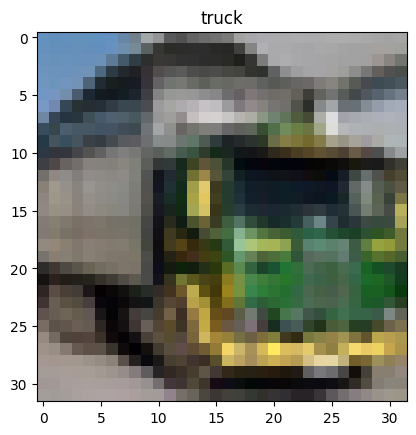

In [147]:
n = 14
image, label = train_data[n]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[labels[n]])

In [42]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Функциональное обучение

In [43]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Total time on {device}: {total_time:.3f} seconds.")
    return total_time

In [44]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("hepler_functions.py", "wb") as f:
        f.write(request.content)

In [45]:
"""def accuracy_fn(y_preds: torch.Tensor,
                y_true: torch.Tensor)->torch.float:
                correct = torch.eq(y_preds, y_true).sum().item()
                acc = (correct / len(y_preds))*100
                return acc"""
from hepler_functions import accuracy_fn          

In [51]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model.forward(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 500 == 0:
            print(f"Batch {batch}: {batch* len(X)}/{len(data_loader.dataset)} samples.")
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [88]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    history_score = []
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            test_pred = model.forward(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))
            history_score.append((test_acc/(batch+1)))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")
    return history_score

In [53]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    """
    Функция для оценки модели
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X = X.to(device)
            y = y.to(device)
            y_logits = model.forward(X)
            y_preds = torch.argmax(y_logits, dim=1)
            loss += loss_fn(y_logits, y)
            acc += accuracy_fn(y_preds=y_preds,
                               y_true=y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

## Model_0

In [102]:
class ModelV0(nn.Module):
    """
    LeNet без ReLU и MaxPool
    """
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=12,
                      kernel_size=5,
                      padding=2,
                      stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12288,
                      out_features=84),
            nn.Linear(in_features=84,
                      out_features=10)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

In [103]:
model_0 = ModelV0().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [104]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42

from timeit import default_timer as timer
train_time_start_model_0 = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    history_score_model_0 = test_step(model=model_0,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device)
train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                            end=train_time_end_model_0,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.86021 | Train acc: 34.71%
Test loss: 1.75438 | Test acc: 39.36%

Epoch: 1
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.73573 | Train acc: 40.29%
Test loss: 1.71839 | Test acc: 40.80%

Epoch: 2
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.71325 | Train acc: 41.45%
Test loss: 1.71283 | Test acc: 40.68%

Total time on cuda: 35.242 seconds.


## ModelV1

In [59]:
class ModelV1(nn.Module):
    """
    LeNet с ReLU и без MaxPool
    """
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=12,
                      kernel_size=5,
                      padding=2,
                      stride=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12288,
                      out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84,
                      out_features=10)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

In [60]:
model_1 = ModelV1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [93]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42

from timeit import default_timer as timer
train_time_start_model_1 = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    history_score_model_1 = test_step(model=model_1,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device)
train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                            end=train_time_end_model_1,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.43545 | Train acc: 48.77%
Test loss: 1.44929 | Test acc: 48.10%

Epoch: 1
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.43552 | Train acc: 48.76%
Test loss: 1.44929 | Test acc: 48.10%

Epoch: 2
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.43533 | Train acc: 48.78%
Test loss: 1.44929 | Test acc: 48.10%

Total time on cuda: 49.132 seconds.


## ModelV2

In [65]:
class ModelV2(nn.Module):
    """
    LeNet с ReLU и MaxPool
    """
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=12,
                      kernel_size=5,
                      padding=2,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=(2,2)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3072,
                      out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84,
                      out_features=10)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

In [95]:
model_2 = ModelV2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [96]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42

from timeit import default_timer as timer
train_time_start_model_2 = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    history_score_model_2 = test_step(model=model_2,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 2.00571 | Train acc: 27.28%
Test loss: 1.77228 | Test acc: 37.18%

Epoch: 1
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.68170 | Train acc: 40.00%
Test loss: 1.54271 | Test acc: 45.00%

Epoch: 2
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.52411 | Train acc: 45.58%
Test loss: 1.45502 | Test acc: 47.29%

Total time on cuda: 50.281 seconds.


## ModelV3

In [72]:
class ModelV3(nn.Module):
    """
    LeNet с ReLU и MaxPool, с 2 сверточными слоями
    """
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=9,
                      kernel_size=5,
                      padding=2,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=(2,2)),
            nn.Conv2d(in_channels=9,
                      out_channels=27,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=(2,2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1323,
                      out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,
                      out_features=10)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [97]:
model_3 = ModelV3().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.01)

In [98]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42

from timeit import default_timer as timer
train_time_start_model_3 = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model=model_3,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    history_score_model_3 = test_step(model=model_3,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device)
train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_model_3,
                                            end=train_time_end_model_3,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 2.10449 | Train acc: 23.25%
Test loss: 1.89039 | Test acc: 33.55%

Epoch: 1
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.77443 | Train acc: 36.69%
Test loss: 1.63057 | Test acc: 41.79%

Epoch: 2
----------------------
Batch 0: 0/50000 samples.
Batch 500: 16000/50000 samples.
Batch 1000: 32000/50000 samples.
Batch 1500: 48000/50000 samples.
Train loss: 1.54220 | Train acc: 44.92%
Test loss: 1.44321 | Test acc: 48.46%

Total time on cuda: 64.903 seconds.


## Визуализация

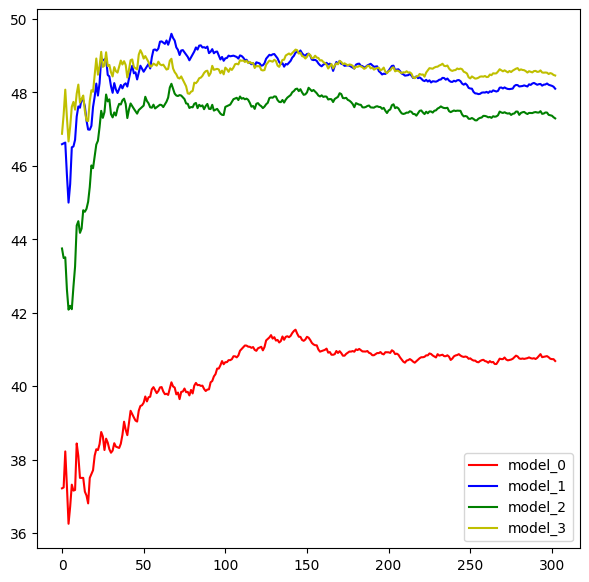

In [150]:
plt.figure(figsize=(7,7))
plt.plot(history_score_model_0[10:],
         c="r",
         label="model_0")
plt.plot(history_score_model_1[10:],
         c="b",
         label="model_1")
plt.plot(history_score_model_2[10:],
         c="g",
         label="model_2")
plt.plot(history_score_model_3[10:],
         c="y",
         label="model_3")
plt.legend()
plt.show()

In [124]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Make predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_3.forward(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
print(y_preds_tensor.size())

Make predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])


In [127]:
confmat = ConfusionMatrix(num_classes=10,
                          task="multiclass")
confmat_tensor = confmat(preds=y_preds_tensor, 
                         target=torch.tensor(test_data.targets))

In [134]:
confmat_tensor

tensor([[503,  51,  64,  30,  28,  35,  24,  56, 163,  46],
        [ 55, 537,   6,  41,  12,  14,  28,  35,  73, 199],
        [ 62,  29, 267, 100, 144, 106, 165,  88,  19,  20],
        [ 22,  22,  59, 343,  62, 175, 192,  69,  11,  45],
        [ 50,  17, 111,  74, 337,  60, 200, 117,  15,  19],
        [ 10,   7,  84, 230,  64, 346, 118, 110,  12,  19],
        [  9,  13,  59,  96, 112,  26, 627,  33,  10,  15],
        [ 27,  23,  39,  70,  85, 101,  55, 545,  15,  40],
        [158,  75,  17,  42,  11,  21,  20,  27, 550,  79],
        [ 55, 171,   9,  54,  11,  18,  39,  48,  90, 505]])

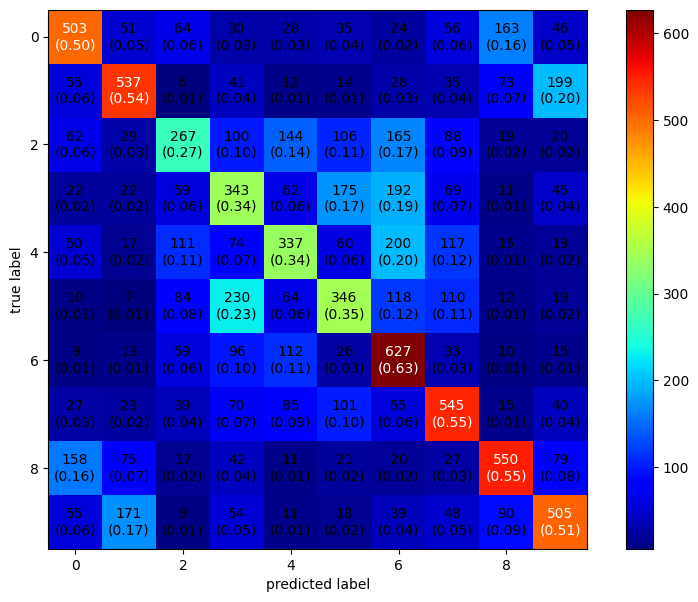

In [156]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='jet',
                                figsize=(10, 7))

In [152]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}